In [2]:
import sys
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
import os
import glob
import pickle
from time import time
from time import strftime
from collections import OrderedDict
from importlib import reload
import random 

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
import scipy.signal as signal
import statsmodels.api as sm
import astropy.stats.circstats as circstats

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'small'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
import neurodsp
#from cluster_helper.cluster import cluster_view
from ptsa.data.TimeSeriesX import TimeSeries 
#from ptsa.data.filters import MorletWaveletFilter
from ptsa.data.filters import ButterworthFilter
#from ptsa.data.filters import MonopolarToBipolarMapper
import manning_utils
import manning_analysis
import phase_locking
from eeg_plotting import plot_trace

In [3]:
## Setup project.
dirs, subj_info, config, subj_df, subj_df_file = manning_analysis.setup_session()
proj_dir = '/scratch/dscho/unit_activity_and_hpc_theta'
data_dir = dirs['data']
figure_dir = dirs['figs']
ccg_dir = '/scratch/dscho/unit_activity_and_hpc_theta'
spikes_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/spikes'

# Figure out which subjects have dataframes in metadata.
files = glob.glob(os.path.join(data_dir, 'metadata', 'subj_df_*.xlsx'))
subj_df = pd.read_excel(files[0], converters={'chan': str})
for f in files[1:]:
    subj_df = subj_df.append(pd.read_excel(f, converters={'chan': str}))
subj_df = subj_df.loc[subj_df.location!='none']

# Get a dictionary of all channels with 1+ units.
spike_chans = OrderedDict(subj_df.loc[subj_df.n_clusters>0][['subj_sess', 'chan']].groupby('subj_sess').chan.apply(list))

# Get kept channels.
with open(os.path.join(data_dir, 'other', 'keep_chans.pkl'), 'rb') as f:
    keep_chans = pickle.load(f)     
sessions = sorted(keep_chans.keys())

# Get unit pairs.
with open(os.path.join(spikes_dir, 'unit_pairs_df.pkl'), 'rb') as f:
    unit_pairs_df = pickle.load(f)   
    
# Add these columns if they don't exist.    
for subj_sess in sorted(unit_pairs_df.keys()):
    unit_pairs_df[subj_sess].insert(0, 'unit_pair', unit_pairs_df[subj_sess].unit1.map(str) + '_' + unit_pairs_df[subj_sess].unit2.map(str))
    unit_pairs_df[subj_sess].insert(0, 'subj_sess', subj_sess)
    
print('{} sessions'.format(len(sessions)))

Loading subjects DataFrame: /data3/scratch/dscho/frLfp/data/subj_df.xlsx

There are 20 subjects, 46 sessions, and 2944 channels in the study.

46 sessions will be processed: ['U367_env2', 'U369_env1', 'U369_env2', 'U370_env1', 'U371_env1', 'U371_env2', 'U371_env3', 'U372_ses1', 'U372_ses2', 'U373_ses1', 'U373_ses2', 'U373_ses3', 'U374_ses1', 'U374_ses2', 'U379_ses1', 'U380_ses1a', 'U380_ses2', 'U380_ses3', 'U381_ses1', 'U381_ses2', 'U381_ses3', 'U384_ses1', 'U384_ses2', 'U384_ses3', 'U385_ses1', 'U385_ses2', 'U385_ses3', 'U385_ses4', 'U386_ses1', 'U386_ses2', 'U387_ses1', 'U387_ses2', 'U387_ses3', 'U390_ses1', 'U390_ses2', 'U390_ses3', 'U390_ses4', 'U392_ses1', 'U393_ses2', 'U394_ses1', 'U394_ses3', 'U395_ses1', 'U395_ses2', 'U395_ses3', 'U396_ses2', 'U396_ses3']
0 sessions have missing input files and will not be processed.

46 sessions


In [75]:
subj_df.columns

Index(['subj_sess', 'subj', 'sess', 'chan', 'location', 'sess_duration',
       'raw_lfp_file', 'spike_times_file', 'input_files_exist', 'process_chan',
       'n_clusters', 'proc_lfp_file', 'session_spikes_file'],
      dtype='object')

In [83]:
# How many hippocampal units are there per session?
subj_df.query("(location == ['LAH', 'LMH', 'LPH', 'RAH', 'RMH', 'RPH'])").groupby(['subj_sess']).n_clusters.sum()

In [84]:
subj_sess = 'U371_env1'
with open(os.path.join('/data3/scratch/dscho/frLfp/data/spikes', '{}_session_spikes.pkl'.format(subj_sess)), 'rb') as f:
    spikes = pickle.load(f)
fr_df, clus_to_chan, chan_to_clus = manning_analysis.get_fr_df(subj_sess, spikes)
fr_df.insert(6, 'n_spikes', fr_df.spikes.apply(np.sum))
units = fr_df.clus.tolist()

In [96]:
fr_df.groupby('location').count()

,subj_sess,chan,pct_interp,clus,chan_clus,n_spikes,mean_fr,fr,spikes,interp_mask
location,,,,,,,,,,
LA,17,17,17,17,17,17,17,17,17,17
LAH,4,4,4,4,4,4,4,4,4,4
LEC,10,10,10,10,10,10,10,10,10,10
LPG,13,13,13,13,13,13,13,13,13,13
LPH,11,11,11,11,11,11,11,11,11,11
REC,5,5,5,5,5,5,5,5,5,5
RMH,3,3,3,3,3,3,3,3,3,3


In [94]:
clus = 8
spike_train = fr_df.at[clus, 'spikes']
spike_times = np.where(spike_train)[0]
isis = np.diff(spike_times)
isis = np.append(np.median(isis), isis)

(55, 3445, 0.015714285714285715)

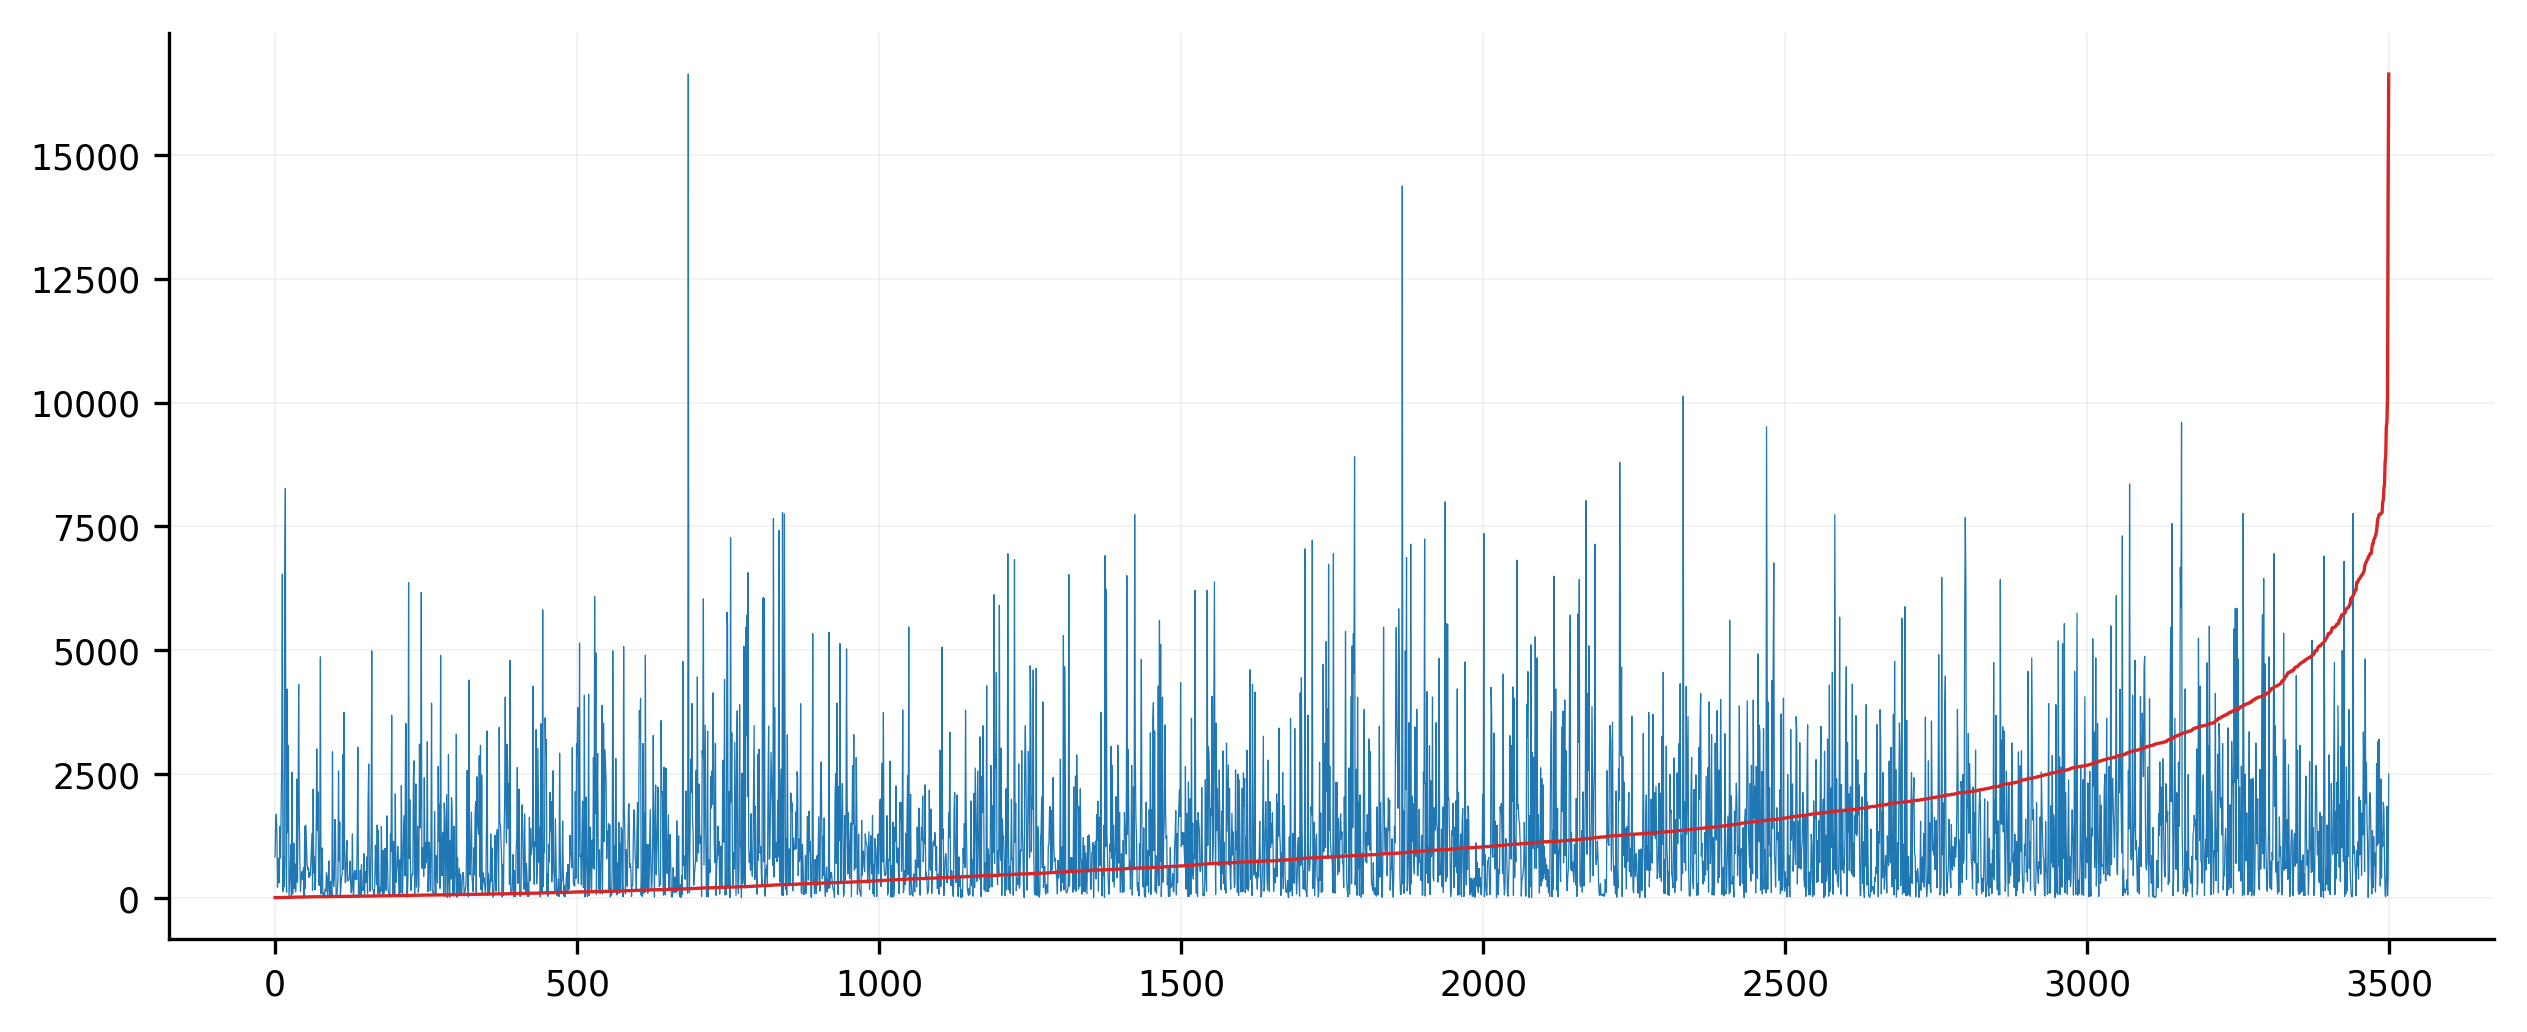

In [95]:
plt.figure(figsize=(10,4), dpi=300)
plt.plot(isis, linewidth=0.3)
plt.plot(np.sort(isis))
np.sum(isis<20), np.sum(isis>=20), np.sum(isis<20)/len(isis)  # 10ms diff